<a href="https://colab.research.google.com/github/paula-rj/StratoPy/blob/main/Abrir_y_graficar_archivos_Cldclass_con_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Abrir archivos CLDCLASS y graficarlos con Python

## Manuales
[Cloudsat](https://ccplot.org/pub/resources/CloudSat/CloudSat%20Data%20Users%20Handbook.pdf)

[Archivos CLDCLASS](http://www.cloudsat.cira.colostate.edu/sites/default/files/products/files/2B-CLDCLASS_PDICD.P1_R05.rev1_.pdf) de Cloudsat, manual más actualizado.


[VS data](http://pysclint.sourceforge.net/pyhdf/pyhdf.VS.html) en pyhdf

[Fuente](https://docserver.gesdisc.eosdis.nasa.gov/public/project/MEaSUREs/Fetzer/README.AIRS_CloudSat.pdf) de la mayor parte del codigo

# Instalar librerías
Primero instalamos todas las librerias que haya que instalar. 

En Colab estas serian:
Geopandas, Basemap, PyHDF, Cartopy, NetCDF4.

En Kaggle: PyHDF, Cartopy.

In [ ]:
#Instalar basemap
#No lo estoy usando porque 'is depracated in favor of cortopy' pero bueno lo dejo acá por las dudas
#!apt-get install libgeos-3.5.0
#!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
#Si estas en kaggle, pasar o comentar esta linea, no hace falta
!pip install geopandas
!pip install cartopy
!pip install netcdf4
!pip install contextily       # Sirve para poner un mapa base estilo los del gps abajo de los graficos de Geopandas
!pip install numpy --upgrade

In [ ]:
%%bash
apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y

In [ ]:
#Instalar pyhdf
%%bash
!pip install pyhdf #git+https://github.com/hdfeos/pyhdf.git

In [ ]:
#Si estas en kaggle, pasar o comentar esta linea, no hace falta
#En Colab Cartopy se rompe si no tiene instalados estos paquetes (2021)
!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force

In [66]:
#Importamos varias librerías necesarias 
import numpy as np
import pyhdf
from pyhdf.HDF import *
from pyhdf.VS import *
import pprint
import matplotlib.pyplot as plt

import os, sys, matplotlib
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import linspace
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
#import geopandas as gpd
import seaborn as sns

from pyhdf.SD import SD, SDC  

import cartopy.crs as ccrs  # Plot maps

In [ ]:
#NO usé esta funcion pero la dejo por si sirve
def cmap_discretize(cmap, n):
  
    #Return a discrete colormap from the continuous colormap cmap.
    #cmap: colormap instance, eg. cm.jet.
    #n: number of colors.
    #Example
    #x = resize(arange(100), (5,100))
    #djet = cmap_discretize(cm.jet, 5)
    #imshow(x, cmap=djet)
    
  cdict = cmap._segmentdata.copy()
  # n colors
  colors_i = linspace(0,1.,n)
  # n+1 indices
  indices = linspace(0,1.,n+1)
  for key in ('red','green','blue'):
 # Find the n colors
    D = np.array(cdict[key])
    I = interpolate.interp1d(D[:,0], D[:,1])  
    colors = I(colors_i)
 # Place these colors at the correct indices.
    A = np.zeros((n+1,3), float)
    A[:,0] = indices
    A[1:,1] = colors
    A[:-1,2] = colors
 # Create a tuple for the dictionary.
    L = []
    for l in A:
      L.append(tuple(l))
    cdict[key] = tuple(L)
 # Return colormap object.
  return LinearSegmentedColormap('colormap',cdict,1024)

# Importar archivos

# Abrir archivos CLDCLASS con PyHDF
Algunos tutoriales:

Ver las [variables](https://stackoverflow.com/questions/31003968/fields-not-found-when-using-pyhdf) con pyhdf

Documentacion sobre los módulos VS y SD de [pyhdf](http://pysclint.sourceforge.net/pyhdf/documentation.html)

Abrir [hdf's](https://hdfeos.org/zoo/LaRC/CER_ES4_Aqua-FM3_Edition1-CV_024032.200908.hdf.py) con pyhdf versus con netcdf4

**Leer y explorar archivos .hdf con pyhdf: **
Fuente: esta [pagina](http://fhs.github.io/pyhdf/modules/SD.html). Tambien explican algunas funciones incuilas en la libreria pyhdf.

Ahora leemos las variables directamente desde los archivos hdf.
Esta parte la saque de [aqui](https://moonbooks.org/Codes/Plot-cldclass-lidar-granule-vertical-profile-using-python-3/)

Una partecita de la documentación acerca del formato vdata:

  List of vdata descriptions. Each vdata is described as
  a 9-element tuple, composed of the following:

    - vdata name
    - vdata class
    - vdata reference number
    - vdata number of records
    - vdata number of fields
    - vdata number of attributes
    - vdata record size in bytes
    - vdata tag number
    - vdata interlace mode

In [12]:
#Path del archivo CLDCLASS
path = './data/CloudSat/2019003183652_67566_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf'

Abrimos la sección del archivo tipo HDF donde estan las variables en formato VS (Vdata table, tablas de datos estructuradas dentro del archivo HDF; mas info [acá](http://pysclint.sourceforge.net/pyhdf/pyhdf.VS.html)). Acá estan todas las variables que tienen que ver con ubicación en tiempo y espacio del satélite, en particular latitud, longitud, y tiempo utc. Como vemos son tuplaas de 9 elementos como indica la documentación.

In [13]:
hdf_file = HDF(path, HC.READ)
vs = hdf_file.vstart()
vdata = vs.vdatainfo() #es una lista de tuplas. acá estan lat y long y cloud layers
vdata

[('Profile_time', '', 7, 36951, 1, 0, 4, 1962, 0),
 ('UTC_start', '', 8, 1, 1, 0, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 0, 8, 1962, 0),
 ('Latitude', '', 10, 36951, 1, 0, 4, 1962, 0),
 ('Longitude', '', 11, 36951, 1, 0, 4, 1962, 0),
 ('Range_to_intercept', '', 13, 36951, 1, 0, 4, 1962, 0),
 ('DEM_elevation', '', 14, 36951, 1, 0, 2, 1962, 0),
 ('Vertical_binsize', '', 15, 1, 1, 0, 4, 1962, 0),
 ('Pitch_offset', '', 16, 1, 1, 0, 4, 1962, 0),
 ('Roll_offset', '', 17, 1, 1, 0, 4, 1962, 0),
 ('Data_quality', '', 18, 36951, 1, 0, 1, 1962, 0),
 ('Data_status', '', 19, 36951, 1, 0, 2, 1962, 0),
 ('Data_targetID', '', 20, 36951, 1, 0, 1, 1962, 0),
 ('RayStatus_validity', '', 21, 36951, 1, 0, 1, 1962, 0),
 ('Navigation_land_sea_flag', '', 22, 36951, 1, 0, 1, 1962, 0),
 ('Precip_flag', '', 23, 36951, 1, 0, 1, 1962, 0),
 ('SST', '', 24, 36951, 1, 0, 4, 1962, 0),
 ('Surface_wind', '', 25, 36951, 1, 0, 4, 1962, 0),
 ('CloudLayer', '', 28, 36951, 1, 0, 2, 1962, 0),
 ('nray:2B-CLDCLASS', 'DimVal0.1

In [14]:
#Abrimos la variable Latitude
vd = vs.attach('Latitude', write=0)

#veamos algunos atributos
print("vdata: ", vd._name)      # predefined attribute: vdata name
print("nrecs: ", vd._nrecs)     # predefined attribute:  num records

vdata:  Latitude
nrecs:  36951


In [15]:
# Read all records at once, and loop over the sequence.
lat = vd[:]

# Cerramos la variable
vd.detach

<bound method VD.detach of <pyhdf.VS.VD object at 0x0000023DC1FE7580>>

In [16]:
#Abrimos la variable Longitude
vd = vs.attach('Longitude', write=0)

#veamos algunos atributos
print("vdata: ", vd._name)      # predefined attribute: vdata name
print("nrecs: ", vd._nrecs)     # predefined attribute:  num records

# Read all records at once, and loop over the sequence.
lon = vd[:]
# Cerramos la variable
vd.detach
# terminate the vdata interface
vs.end()                 

vdata:  Longitude
nrecs:  36951


Veamos los primeros elementos de los vectores lat y lon, que serian la latitud y longitud donde empiezan esta orbita en particular.

In [17]:
lat[0], lon[0]

([-0.004875324200838804], [107.62960052490234])

Convertimos lat y lon en un vector como objeto de numpy, simplemente le damos nueva forma

In [18]:
latitud = np.array(lat).flatten()
print(latitud.shape)

longitud = np.array(lon).flatten()
print(longitud.shape, type(longitud))

(36951,)
(36951,) <class 'numpy.ndarray'>


In [19]:
hdf_file.close()  # Cerramos el archivo HDF file. A veces anda y a veces no, 
#si tira error no importa, seguir con el resto del codigo

HDF4Error: close (42): There are still active AIDs

Ahora leemos las variables que estan en formato SD (scientific
dataset, similar al netCDF; más info [acá](http://pysclint.sourceforge.net/pyhdf/pyhdf.SD.html)) dentro del mismo HDF. 

En este formato se encuetran la altura 'Height' y las clasificaciones de nubes segun altura o capa.

In [20]:
from pyhdf.SD import SD, SDC    
file = SD(path, SDC.READ)  
file.datasets()

{'Height': (('nray:2B-CLDCLASS', 'nbin:2B-CLDCLASS'), (36951, 125), 22, 0),
 'cloud_scenario': (('nray:2B-CLDCLASS', 'nbin:2B-CLDCLASS'),
  (36951, 125),
  22,
  1),
 'CloudLayerBase': (('nray:2B-CLDCLASS', 'Ncloud:2B-CLDCLASS'),
  (36951, 10),
  5,
  2),
 'CloudLayerTop': (('nray:2B-CLDCLASS', 'Ncloud:2B-CLDCLASS'),
  (36951, 10),
  5,
  3),
 'CloudLayerType': (('nray:2B-CLDCLASS', 'Ncloud:2B-CLDCLASS'),
  (36951, 10),
  22,
  4)}

Exploramos algunas variables

In [21]:
print('---------- CloudScenario ----------')

sds_obj = file.select('cloud_scenario') # select sds
cloud_scenario = sds_obj.get()
sds_info = sds_obj.info()

print(cloud_scenario.shape)
print( sds_info )
print( sds_info[0], sds_info[1] )
print( 'sds attributes' )
pprint.pprint( sds_obj.attributes() )

for i in range(10):
	print([cloud_scenario[i, j] for j in range(10)])

---------- CloudScenario ----------
(36951, 125)
('cloud_scenario', 2, [36951, 125], 22, 0)
cloud_scenario 2
sds attributes
{}
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]
[2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113, 2113]


In [ ]:
#cloud_scenario[12580:13580,-1]

In [22]:
print('---------- CloudLayerType ----------')

sds_obj = file.select('CloudLayerType') # select sds

CloudLayerType = sds_obj.get() 

sds_info = sds_obj.info()

print(CloudLayerType.shape)
print( sds_info )
print( sds_info[0], sds_info[1] )
print( 'sds attributes' )
pprint.pprint( sds_obj.attributes() )

for i in range(10):
	print([CloudLayerType[i,j] for j in range(10)])


---------- CloudLayerType ----------
(36951, 10)
('CloudLayerType', 2, [36951, 10], 22, 0)
CloudLayerType 2
sds attributes
{}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Extraemos las variables que nos interesan y las guardamos en arrays. En este caso solo quiero hacer los graficos de una capa en coordenadas lat, lon y el de las nubes segun cada capa vs altura, por lo que voy a extraer las variables para hacer esos gráficos:

In [23]:
cld_layertype= file.select('CloudLayerType')[:]
layer_base = file.select('CloudLayerBase')[:]
layer_top = file.select('CloudLayerTop')[:]
height = file.select('Height')[:]

Cloud types es una matriz de 36mil y pico x 125, que da el tipo de nube segun la altura. Observar que la forma coincide con la de height por lo que se puede plottear altura vs latitud o longitud con tipos de nubes.

Cloud layer type da el tipo de nube segun la capa, dividiendo toda la altura en 10 capas. Tambien se podria graficar tipo de nube vs capa por latura usando las variables cloud layer base y cloud layer top.

Exploremos un poco la matriz height.

In [26]:
matrix = np.argwhere(height[:,:] != -99)
matrix.shape

(4618794, 2)

In [27]:
height[matrix[0]]

array([[-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
        -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999],
       [-999

In [ ]:
#arr = np.array([height[matrix[0]], cloud_scenario[matrix[0]]])
#arr[0:5,:].T

Exploramos un poco las variables layer base y layer top

In [28]:
print(layer_base[3876,:])
print(layer_top[3876,:])
print(cld_layertype[3876,:])
print('lat', latitud[3876])
print('lon', longitud[3876])

[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99.]
[0 0 0 0 0 0 0 0 0 0]
lat -37.472877502441406
lon 98.76490783691406


In [29]:
print(f"Shape layer type={cld_layertype.shape}, shape height= {height.shape}, shape layer base={layer_base.shape}, shape layer top={layer_top.shape}, shape lat ={np.shape(latitud)}, shape lon={ np.shape(longitud)}")
#Con esto ya tenemos todo para plotear, por ahora

Shape layer type=(36951, 10), shape height= (36951, 125), shape layer base=(36951, 10), shape layer top=(36951, 10), shape lat =(36951,), shape lon=(36951,)


Elaboramos un diccionario con los códigos del archivo, segun cada numero se asigna un tipo de nube (ver manual cldclass, ahi está descripto)

In [30]:
dic_LayerType = {0:'no',
                 1:'Ci',
                 2:'As',
                 3:'Ac',
                 4:'St',
                 5:'Sc',
                 6:'Cu',
                 7:'Ns',
                 8:'DC'}

# Ploteos

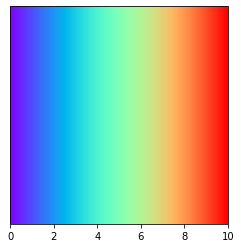

In [42]:
import matplotlib as mpl

fig, ax = plt.subplots() 
plt.imshow(cld_layertype[12346:12446, :].T, vmin=0, vmax=10, origin='lower', cmap='rainbow')
norm = mpl.colors.Normalize(vmin=0, vmax=10)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='rainbow'),
             cax=ax, orientation='horizontal' )

## Una capa proyectada segun GOES
Vamos a utilizar Geopandas para proyectar una capa de las de cloudsat según la proyección del satelite GOES16 y dibujarla sobre ese mapa.

Creamos un dataframe de pandas conteniendo la latitud, longitud y valores del tipo de nube en cada una de las 10 capas.

In [43]:
tipo_capa = pd.DataFrame({'Longitude': longitud, 'Latitude': latitud, 
                          'capa0':cld_layertype[:,0], 'capa1':cld_layertype[:,1],
                          'capa2':cld_layertype[:,2], 'capa3':cld_layertype[:,3],
                          'capa4':cld_layertype[:,4], 'capa5':cld_layertype[:,5],
                          'capa6':cld_layertype[:,6], 'capa7':cld_layertype[:,7],
                          'capa8':cld_layertype[:,8], 'capa9':cld_layertype[:,9]})

Exploremos los elementos del dataframe

In [44]:
tipo_capa.head() #muestra los primeros valores de la tabla para lat, log y cada una de las capas

,Longitude,Latitude,capa0,capa1,capa2,capa3,capa4,capa5,capa6,capa7,capa8,capa9
0,107.629601,-0.004875,0,0,0,0,0,0,0,0,0,0
1,107.627548,-0.014581,0,0,0,0,0,0,0,0,0,0
2,107.625504,-0.024287,0,0,0,0,0,0,0,0,0,0
3,107.623451,-0.033994,0,0,0,0,0,0,0,0,0,0
4,107.621399,-0.043700,0,0,0,0,0,0,0,0,0,0


In [45]:
tipo_capa.iloc[12876,:]

Longitude   -69.587791
Latitude    -54.083961
capa0         2.000000
capa1         0.000000
capa2         0.000000
capa3         0.000000
capa4         0.000000
capa5         0.000000
capa6         0.000000
capa7         0.000000
capa8         0.000000
capa9         0.000000
Name: 12876, dtype: float64

Comprobamos que exista algun valor distinto de 0 para los tipos de nubes de la capa 0 por ejemplo.

In [46]:
tipo_capa.loc[tipo_capa.capa0.isin([5])]

,Longitude,Latitude,capa0,capa1,capa2,capa3,capa4,capa5,capa6,capa7,capa8,capa9
7387,79.196373,-70.312141,5,0,0,0,0,0,0,0,0,0
7388,79.183662,-70.320923,5,0,0,0,0,0,0,0,0,0
7389,79.170944,-70.329712,5,0,0,0,0,0,0,0,0,0
7390,79.158234,-70.338493,5,0,0,0,0,0,0,0,0,0
7391,79.145477,-70.347275,5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27917,166.079544,81.668587,5,3,0,0,0,0,0,0,0,0
27918,166.013626,81.666420,5,5,0,0,0,0,0,0,0,0
28239,147.121567,80.478836,5,0,0,0,0,0,0,0,0,0
28240,147.070679,80.473801,5,0,0,0,0,0,0,0,0,0


In [47]:
base = pd.DataFrame({'Longitude': longitud, 
                          'capa0':layer_base[:,0], 'capa1':layer_base[:,1],
                          'capa2':layer_base[:,2], 'capa3':layer_base[:,3],
                          'capa4':layer_base[:,4], 'capa5':layer_base[:,5],
                          'capa6':layer_base[:,6], 'capa7':layer_base[:,7],
                          'capa8':layer_base[:,8], 'capa9':layer_base[:,9]})

In [48]:
top = pd.DataFrame({'Longitude': longitud, 'Latitude': latitud, 
                          'capa0':layer_top[:,0], 'capa1':layer_top[:,1],
                          'capa2':layer_top[:,2], 'capa3':layer_top[:,3],
                          'capa4':layer_top[:,4], 'capa5':layer_top[:,5],
                          'capa6':layer_top[:,6], 'capa7':layer_top[:,7],
                          'capa8':layer_top[:,8], 'capa9':layer_top[:,9]})

## Ploteo de altura vs longitud para cada capa
No anda! Hay que arreglarlo; seria una especie de histograma o algo asi con las alturas fijas

In [49]:
#Comprobamos que haya algun valor distinto de -99 que es missing value en Layer Base
for i in range(layer_base.shape[0]):
	nb_cloud_layer = np.where(layer_base[i,:] < 0 )

nb_cloud_layer

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)

In [ ]:
f = plt.figure()
ax = f.add_subplot(111)

#for i in range(CloudLayerBase.shape[0]):
for i in range(layer_base.shape[0]):
	nb_cloud_layer = np.where(layer_base[i,:] < 0 )[0][0]
	for j in range(10):
		if layer_base[i,j] > 0 and layer_top[i,j] > 0.0:
			bar_xi = i
			bar_width = 1.0
			bar_base = layer_base[i,j] 
			bar_height = layer_top[i,j] - bar_base
            layer_phase = cld_layertype[i,j]
			bar_color = '1.0'
        if layer_phase == 0:
                      bar_color = 'white'
                    if layer_phase == 1:
                        bar_color = 'royalblue'
                    if layer_phase == 2:
                        bar_color = 'firebrick'
			bar_edgecolor = '1.0'
			plt.bar(left=bar_xi, height=bar_height, width=bar_width, bottom=bar_base, color=bar_color, edgecolor=bar_edgecolor)
                    
                        

#plt.bar(bar_xi, bar_height, width=bar_width, bottom=bar_base, color=bar_color, edgecolor=bar_edgecolor)
ax.set_facecolor('xkcd:lightblue')

plt.legend()

plt.ylim(0,20)

#xticks_idx = [int(i) for i in np.linspace(cldclass_lidar_start_idx,cldclass_lidar_end_idx,10)]
#xticks_latitude = [ "{0:.2f}".format(latitude_table[i][0]) for i in xticks_idx]
#plt.xticks(xticks_idx, xticks_latitude,rotation=45)

plt.xlabel('Latitude')
plt.ylabel('Altitude (in km)')

plt.title('Cloud Mask')

plt.show()

In [ ]:
ax = base.plot.bar(x='Longitude', stacked=True)

## Latitud vs longitud, scatterplot de la capa
Primero voy a dibujar sin mapa, solo latitud, longitud y los tipos de nubes para cada coordenada.

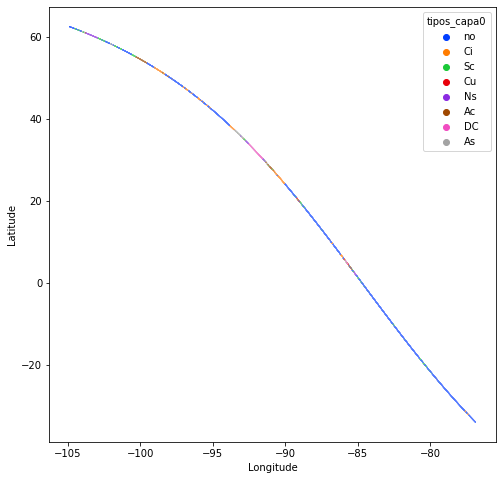

In [63]:
#Ploteo de capa 0 en lat,lon sin proyeccion
def latlonplot(tipo_capa):
  fig_dims = (8, 8)
  fig, ax = plt.subplots(figsize=fig_dims)
  sns.scatterplot(x='Longitude', y='Latitude', data= tipo_capa.assign(tipos_capa0 =tipo_capa.capa0.map(dic_LayerType)), 
                  hue='tipos_capa0',palette='bright',marker='o', s=1)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  plt.show()

latlonplot(tipo_capa.iloc[15000:25000,:])

## Con proyeccion geoestacionaria de GOES16

Voy a graficar la capa 0 y la reproyecto a latitud, longitud.

In [ ]:
geo_df = gpd.GeoDataFrame(tipo_capa.loc[:,['Longitude','Latitude','capa0']], 
                          geometry=gpd.points_from_xy(tipo_capa.Longitude, tipo_capa.Latitude))
geo_df.crs = {'init': 'epsg:4326'} # EPSG 4326 corresponds to coordinates in latitude and longitude

In [ ]:
geo_df.loc[geo_df.capa0.isin([1])] 
#vemos que se agrega esa tabla geometry que es lo que usa geopandas para proyectar despues

In [ ]:
  #dibujo con proyección mercator epsg=32630, con mapa estilo gps de fondo
#import contextily as cx
#ax = geo_df.to_crs(epsg=32630).plot(figsize=(8,10), cmap= cmap_discretize(cm.gist_ncar_r, 9)) 
#cx.add_basemap(ax)

In [ ]:
  #Reproyectar al sistema de GOES cada uno de los puntos
geodf_toGOES = geo_df.to_crs("+proj=geos +h=35786023.0 +lon_0=-75.0")
geodf_toGOES[]

In [ ]:
crs=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0) #proyeccion geoestacionaria para Goes16

In [ ]:
fig_dims = (10, 10)
fig, axis = plt.subplots(figsize=fig_dims)

axis = plt.axes(projection=crs)
axis.gridlines 
axis.coastlines(resolution='10m',color='blue') 
sns.scatterplot(x='Longitude', y='Latitude', data=geodf_toGOES.iloc[10000:20000,:], hue='capa0',palette='bright',s=2, transform=ccrs.PlateCarree())
#el transform es lo que hace que el sns se dibuje sobre el mapa
#geo_df.to_crs("+proj=geos +h=35786023.0 +lon_0=-75.0").plot(figsize=(10,10), ax=axis) esto funcionaria pero hay que agregarle un cmap

# Clases finales

Finalmente definimos clases y funciones que realizan el procedimiento explicado anteriormente para que sea mas facil realizarlo para muchos archivos y el codigo sea mas reproducible. 

In [70]:
class CldClass:
  def __init__(self,path_total):
    self.path_total = path_total
    self.file_name = os.path.split(self.path_total)[-1]
    date = self.file_name.split('_')[0]
    self.year = date[:4]
    self.julian_day = date[4:7]
    self.hour_utc = date[7:9]
    self.light=''
    if int(self.hour_utc)>10:
      self.light='day'
    else:
      self.light='night'
  
  def open_cldclass(self, sur=True):
    """
      Función que toma un path donde debe estar el archivo CLDCLASS de Cloudsat y devuelve un dataframe de Pandas 
    con los datos del archivo cldclass guardados en columnas del dataframe: latitud, longitud, capa0, capa1,..., capa9;
    con cada tipo de nube segun cada capa.
    Parameters:
    -----------
    sur : Bool. Si se quiere abrir solo la parte de sudamerica. Default=True.

    Returns:
    -----------
    layers_df: Pandas Dataframe lat, lon, tipo de nube en cada una de las capas (son 10)
    """
  #Read v data
    hdf_file = HDF(self.path_total, HC.READ)
    vs = hdf_file.vstart()
    vdata = vs.vdatainfo() #es una lista de tuplas. acá estan lat y long y cloud layers

    vd_lat = vs.attach('Latitude', write=0)
    lat = vd_lat[:]
    vd_lat.detach

    vd_lon = vs.attach('Longitude', write=0)
    lon = vd_lon[:]
    vd_lon.detach
    vs.end() 
    #hdf_file.close()

    latitud = np.array(lat).flatten()
    longitud = np.array(lon).flatten()

    #Read sd data
    file = SD(self.path_total, SDC.READ)  
    start_point=0
    end_point=36951
    if sur==True:
      if self.light=='night':
        end_point = 6000 
      else:
        end_point=20000
        if self.hour_utc==(15):
          start_point=6000
        else: #16,17,18 utc
          start_point=10000
      latitud = latitud[start_point:end_point]
      longitud = longitud[start_point:end_point]
      cld_layertype= file.select('CloudLayerType')[start_point:end_point] 
    else: #grafica toda la orbita
      cld_layertype= file.select('CloudLayerType')[:]

    layers_df = pd.DataFrame({'Longitude': longitud, 'Latitude': latitud, 
                            'capa0':cld_layertype[:,0], 'capa1':cld_layertype[:,1],
                            'capa2':cld_layertype[:,2], 'capa3':cld_layertype[:,3],
                            'capa4':cld_layertype[:,4], 'capa5':cld_layertype[:,5],
                            'capa6':cld_layertype[:,6], 'capa7':cld_layertype[:,7],
                            'capa8':cld_layertype[:,8], 'capa9':cld_layertype[:,9]})
    
    return layers_df

  def plot_cldclass_geos(self,layers_data, capa_n):
    """
      Función que grafica los tipos de nubes en la capa asignada en la pasada del Cloudsat.
    Parameters:
    -----------
    layers_data : Pandas Dataframe. 
      Dataframe de Pandas que contiene Latitud,Longitud,y la capa que se quiere graficar.
    capa_n : int
      Numero de capaque se quiere graficar. Van de 0 a 9.

    Returns:
    -----------
    Plot. Tipo de nube en la capa 9 con órbita proyectada en proyeccion geoestacionaria de GOES16, 
    con mapa de costas de fondo.
    """
    capa_str = 'capa' + str(capa_n)

    #Generamos geodataframe a partir del pd dataframe de entrada
    geo_df = gpd.GeoDataFrame(layers_data.loc[:,['Longitude','Latitude',capa_str]], 
                            geometry=gpd.points_from_xy(layers_data.Longitude, layers_data.Latitude))
    geo_df.crs = {'init': 'epsg:4326'} # EPSG 4326 corresponds to coordinates in latitude and longitude
    #Reprojecting into GOES16 geostationary projection 
    geodf_GOESproj = geo_df.to_crs("+proj=geos +h=35786023.0 +lon_0=-75.0")
    crs=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0) #proyeccion geoestacionaria para Goes16
    fig_dims = (10, 10)
    fig, axis = plt.subplots(figsize=fig_dims)
    axis = plt.axes(projection=crs)
    axis.gridlines 
    axis.coastlines(resolution='10m',color='blue') 
    sns.scatterplot(x='Longitude', y='Latitude', data=geodf_GOESproj, hue=capa_str,
                    palette='bright',s=2, transform=ccrs.PlateCarree())
    axis.set_title("""year {}; day {}; hour {}; {}""".format(self.year, self.julian_day, self.hour_utc,self.light))
    plt.show()

  def plotlatlon_cld(self, capa_n, layers_data_df):
    """
       Grafica la capa capa_n con latitud en el eje y y longitud en el eje x, sin ninguna proyeccion
        Parameters
        ----------
        capa_n : int
            El numero de capa que quiero dibujar. Entre 0 y 9.
        layers_data_df : pandas DataFrame
            DataFrame de Pandas o Geopandas que incluya latitud, longitud y la capa que vamos a dibujar.
        Returns
        ----------
        Plot."""

    capa_str = 'capa' + str(capa_n)
    fig_dims = (6, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.scatterplot(x='Longitude', y='Latitude', data=layers_data_df, hue='capa2',palette='bright',marker='o', s=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()


Probemos graficar algunas de interes. 

Vamos a abrir una imagen nocturna del 3 de enero de 2019, de las 00 hs UTM, en sudamérica es de noche. (Editar el path si es necesario)

In [71]:
#Generamos objeto CldClass
night_5= CldClass('./data/CloudSat/2019003052836_67558_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')

In [72]:
#Pedimos que nos de la fecha del archivo, hay dos formas de hacerlo:
night_5.year, night_5.julian_day, night_5.hour_utc, night_5.light

('2019', '003', '05', 'night')

In [73]:
#Abrimos el archivo sólo en la parte de sudamérica
sud_df = night_5.open_cldclass()

In [ ]:
#Pedimos que lo grafique con proyeccion de GOES16
night_5.plot_cldclass_geos(sud_df,0)

Vemos que claramente el sensor no capto ninguna nube en estos horarios. Esto es debido a que la bateria del Cloudsat está rota, por lo que sólo funciona de día, es decir el sol tiene que llegar a los paneles del satélite para que el radar pueda funcionar.

Probemos con una imagen diurna

In [75]:
#Generamos objeto tipo CldClass
day15 = CldClass('./data/CloudSat/2019003151948_67564_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')

In [76]:
day15.light

'day'

In [77]:
day15df = day15.open_cldclass()

In [ ]:
day15.plot_cldclass_geos(day15df,0)

In [79]:
day16 = CldClass('./data/CloudSat/2019003165820_67565_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')

In [80]:
day16df = day16.open_cldclass(sur=False)

In [ ]:
day16.plot_cldclass_geos(day16df,0)

In [82]:
day18 = CldClass('./data/CloudSat/2019003183652_67566_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')


In [83]:
day18df = day18.open_cldclass()

In [ ]:
day18.plot_cldclass_geos(day18df,0)

In [84]:
day2 = CldClass('./data/CloudSat/2019002175851_67551_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')

In [85]:
day2df = day2.open_cldclass()

In [ ]:
day2.plot_cldclass_geos(day2df,0)

In [ ]:
geo_df = gpd.GeoDataFrame(day2df.loc[:,['Longitude','Latitude','capa0']], 
                            geometry=gpd.points_from_xy(day2df.Longitude, day2df.Latitude))
geo_df.crs = {'init': 'epsg:4326'} # EPSG 4326 corresponds to coordinates in latitude and longitude
    #Reprojecting into GOES16 geostationary projection 
geodf_GOESproj = geo_df.to_crs("+proj=geos +h=705000.0 +lon_0=-75.0")

In [ ]:
geodf_GOESproj.shape

In [ ]:
geodf_GOESproj[geodf_GOESproj.Latitude >= 0.]

In [ ]:
lonlat = np.array([geodf_GOESproj.geometry.values.x,geodf_GOESproj.geometry.values.y])
lonlat.shape

In [ ]:
coordinate_list = [[x,y] for x,y in zip(geodf_GOESproj.geometry.values.x,
                                        geodf_GOESproj.geometry.values.y)]
coordinate_list

## Clase GOES: 
La explicación y el paso a paso está en otra notebook, esta es la clase final

In [87]:
class Goes16RGB:
  """
    Clase generadora de matrices listas para graficar imagenes RGB de Goes16 enteras, sin cortar
    ...

    Attributes
    ----------
    Parametros generales 
    LON_CENTRAL : float
        longitud central nominal del satélite GOES16; es siempre la misma.
    SAT_HEIGHT = float
        altura del satélite (perspective_point_height) en metros; es siempre la misma.
        se obtiene de hacer nc_file.variables['goes_imager_projection'].perspective_point_height 
    IMG_EXTENT : list (float)
        extension de la imagen = [x1,x2,y1,y2]*altura satelite donde
        x1 = nc_file.variables['x_image_bounds'][0] * sat_height
        x2 = nc_file.variables['x_image_bounds'][1] * sat_height
        y1 = nc_file.variables['y_image_bounds'][1] * sat_height
        y2 = nc_file.variables['y_image_bounds'][0] * sat_height
    V1 : list (float)
        valores mínimos para el realce por banda sintética en ^oC
    V2 : list (float)
        valores maximos para el realce por banda sintética en ^oC
    EXTENT : list (int)

    cols : int
        columnas de la imagen. Valido para todas las bandas excepto la 3
    rows : int
        filas de la imagen. Valido para todas las bandas excepto la 3.


    path : str
        path principal donde estarán todos los archivos
    bands : list
        lista de bandas o canales a graficar
    sdate_utc : int
        fecha de inicio (lo que esta despues de s en el nombre del archivo) en formato UTC
        YYYYDDDHHMMSSS donde DDD es el dia en juliano

    Methods
    -------
    says(sound=None)
        Prints the animals name and what sound it makes
    """
  LON_CENTRAL = -75.0 # es variable global en la clase
  SAT_HEIGHT = 35786023.0
  IMG_EXTENT = [-5434894.675269887,5434894.675269887,-5434894.675269887,5434894.675269887]
  V1= [-6.7, -3.1, -29.75] 
  V2= [2.6, 5.2, 19.35] 
  EXTENT = [-156 , 6, -81, 81]
  cols = 5424
  rows = 5424
  
  def __init__(self,path_global):
    """
        Parameters
        ----------
        path : str
            El path global donde estan todos los archivos.
        bands : list
            Lista de bandas o canales a graficar. Deben ser 3.
        sdate_utc : int
            Fecha de inicio (lo que esta despues de s en el nombre del archivo) en formato UTC
            Formato: YYYYDDDHHMMSSS donde DDD es el dia en juliano
        """
    self.path_global = path_global

  def night_microphys(self, lista_paths):

    """Devuelve una imágen RGB con night microphysics en un mapa
    proyectada segun la proyeccion geoestacionaria de GOES16.

        Parameters
        ----------
        sound : str, optional
            The sound the animal makes (default is None)

        Returns
        ------
        La matriz RGB lista para graficar.
        """
    cols = 5424
    rows = 5424
    Temp = np.zeros([rows, cols, 3]) #matriz donde vamos a guardar las radiancias
    for i in range(3):
      nc_data = Dataset(self.path_global+lista_paths[0], 'r')
      metadata = nc_data.variables
      channel = int(metadata['band_id'][:])
      fk1 = metadata['planck_fk1'][0] #DN->K
      fk2 = metadata['planck_fk2'][0]
      bc1 = metadata['planck_bc1'][0]
      bc2 = metadata['planck_bc2'][0]
      image_data = metadata['Rad'][:]
      image_data = (fk2 / (np.log((fk1 / image_data) + 1)) - bc1 ) / bc2 - 273.15 #DN -> ^oC
      Temp [:, :, i] = image_data
      Unit = "Temperatura de Brillo [°C]"
      nc_data.close() 

    print ('Haciendo álgebra de bandas y realces.')
    RGB = np.zeros((rows, cols, 3))
    RGB[:, :, 0] = Temp[:,:,2] - Temp[:,:,1]
    RGB[:, :, 1] = Temp[:,:,1] - Temp[:,:,0]
    RGB[:, :, 2] = Temp[:,:,1]

    #Realce gama1 == lineal
    for i in range(3):
      RGB[:, :, i] = realce_lineal(RGB[:, :, i], Goes16RGB.V1[i], Goes16RGB.V2[i])
    return RGB

In [92]:
goesobj = Goes16RGB('./data/GOES16/')

In [93]:
lista_paths = ['OR_ABI-L1b-RadF-M6C07_G16_s20191400530366_e20191400540086_c20191400540122.nc','OR_ABI-L1b-RadF-M6C13_G16_s20191400530366_e20191400540086_c20191400540143.nc','OR_ABI-L1b-RadF-M6C15_G16_s20191400530366_e20191400540080_c20191400540142.nc']

In [90]:
from netCDF4 import Dataset

In [94]:
RGB = goesobj.night_microphys(lista_paths)

C:\Users\julia\AppData\Local\Temp/ipykernel_10516/1254209478.py:94: RuntimeWarning: invalid value encountered in log
  image_data = (fk2 / (np.log((fk1 / image_data) + 1)) - bc1 ) / bc2 - 273.15 #DN -> ^oC


Haciendo álgebra de bandas y realces.


NameError: name 'realce_lineal' is not defined

In [95]:
crs=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0)
#Plot
fig_dims = (10, 10)
fig, axis = plt.subplots(figsize=fig_dims)
axis = plt.axes(projection=crs)
axis.coastlines(resolution='10m',color='w') 
#Arma la grilla de paralelos y meridianos
xlocs = np.arange(-180, 181, 10)
ylocs = np.arange(-80, 81, 10)
axis.gridlines(xlocs=xlocs, ylocs=ylocs, crs=ccrs.PlateCarree(), color='w', linestyle='dotted')

sns.scatterplot(x='Longitude', y='Latitude', data=geodf, hue='capa9',palette='bright',s=5, transform=ccrs.PlateCarree())
axis.imshow(RGB, transform=crs, extent=Goes16RGB.IMG_EXTENT, origin='upper', vmin=-30, vmax=20, aspect='auto')
axis.set_title('DIA 140, HORA 05 UTC')
plt.show()


NameError: name 'geodf' is not defined

C:\Users\julia\miniconda3\envs\stratopy\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

# Transformar hdf a netcdf

[Documentacion](https://www.ncl.ucar.edu/Document/Tools/ncl_convert2nc.shtml) del comando que usamos para convertir 

1º importamos conda

In [ ]:
%%bash
wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')

In [ ]:
!conda create -n ncl_stable -c conda-forge ncl --yes

In [ ]:
!conda update conda -y -q
!source /usr/local/etc/profile.d/conda.sh
!conda init 
!conda install -n root _license -y -q

In [ ]:
%%bash
source activate ncl_stable

python
import sys
# some simple python commands
sys.path.append('/usr/local/lib/python3.6/site-packages')
print(sys.path)

print("Python version")
print(sys.version)

2º importar los archivos que estan guardados en drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Probamos un comando a ver si anda bien. Deberia dar algo como 6.6.2
!source activate ncl_stable && ncl -V

In [ ]:
#Instalamos esto porque si no no anda
%%bash
apt-get install csh

3º convertir a .nc

In [ ]:
!source activate ncl_stable && ncl_convert2nc /content/2010017014344_19801_CS_2B-CLDCLASS_GRANULE_P1_R05_E03_F00.hdf -nc4c

Nota: instalar netcdf antes de hacer todo lo de ncl o abrir una nueva notebook y ahi correr las otras cosas porque sino es un lio, tarda mucho y no se instala porque se hace lio con los environments de conda